In [1]:
import pandas as pd

In [2]:
import os
if os.path.exists("ghost_generics.csv.gz"):
    ghost_df = pd.read_csv("ghost_generics.csv.gz", compression='gzip')
else:
    ghost_df = pd.read_gbq("""
SELECT
  prac.ccg_id,
  rx.practice_code,
  rx.bnf_code,
  rx.bnf_description,
  rx.items,
  rx.quantity,
  rx.nic,
  dt.concession,
  dt.quantity AS dt_quantity,
  dt.price_pence,
  SUM(rx.items*rx.quantity) AS QI,
  ROUND(IEEE_DIVIDE(rx.NIC, (rx.items*rx.quantity)),4) AS rx_ppu,
  ROUND(IEEE_DIVIDE((dt.price_pence/100), dt.quantity),4) AS dt_ppu,
  CASE
    WHEN dt.concession IS NOT NULL THEN ROUND(IEEE_DIVIDE((dt.concession/100), dt.quantity), 4)
    ELSE NULL
  END AS concession_ppu
FROM
  richard.prescribing_2018_09_full AS rx
JOIN
  dmd.dt_viewer AS dt
ON
  rx.bnf_code=dt.bnf_code
JOIN
  hscic.practices AS prac
ON
  rx.practice_code=prac.code
WHERE
  (rx.bnf_description LIKE '%_Tab%'
    OR rx.bnf_description LIKE '%_Cap%')
  AND dt.date='2018-09-01'
  AND rx.bnf_code NOT LIKE '0410020C0%AC'
GROUP BY
  prac.ccg_id,
  rx.practice_code,
  rx.bnf_code,
  rx.bnf_description,
  rx.quantity,
  rx.items,
  rx_ppu,
  dt_ppu,
  dt.concession,
  dt.quantity,
  dt.price_pence,
  rx.NIC
HAVING
  rx_ppu <> dt_ppu
""", 'ebmdatalab', dialect='standard', verbose=False)
    ghost_df.to_csv("ghost_generics.csv")

In [4]:
ghost_df.head(1)

,ccg_id,practice_code,bnf_code,bnf_description,items,quantity,nic,concession,dt_quantity,price_pence,QI,rx_ppu,dt_ppu,concession_ppu
0,99N,J83007,0405010P0AAAAAA,Orlistat_Cap 120mg,1,84,23.95,2395.0,84,1666,84,0.2851,0.1983,0.2851


In [5]:
ghost_df['dt_or_concession_ppu'] = ghost_df['concession_ppu'].combine_first(ghost_df['dt_ppu'])

In [6]:
total_items = ghost_df['items'].sum()
total_presentations = len(ghost_df['bnf_code'].unique())
cheaper = ghost_df[ghost_df['rx_ppu'].round(3) < ghost_df['dt_or_concession_ppu'].round(3)]['items'].sum()
costlier = ghost_df[ghost_df['rx_ppu'].round(3) > ghost_df['dt_or_concession_ppu'].round(3)]['items'].sum()
same = total_items - (cheaper + costlier)
print("There are {} items prescribed for {} presentations. "
      "{}% are cheaper than DT, {}% more expensive, the rest the same".format(
          total_items,
          total_presentations,
          round(cheaper/total_items * 100),
          round(costlier/total_items * 100)
      ))

There are 16781297 items prescribed for 1470 presentations. 9.0% are cheaper than DT, 29.0% more expensive, the rest the same


In [204]:
ghost_df['excess_ppu'] = ghost_df['rx_ppu'] - ghost_df['dt_or_concession_ppu']
ghost_df['excess_ppu_no_concession'] = ghost_df['rx_ppu'] - ghost_df['dt_ppu']
ghost_df['excess_cost_dt_no_concession'] = (ghost_df['excess_ppu_no_concession']) * ghost_df['QI']
ghost_df['excess_cost_dt'] = (ghost_df['excess_ppu']) * ghost_df['QI']
ghost_df = ghost_df.sort_values('excess_cost_dt', ascending=False)

# Summary numbers

In [211]:
total_savings = round(ghost_df['excess_cost_dt'].sum())
total_savings_no_concession = round(ghost_df['excess_cost_dt_no_concession'].sum())
print("Total possible savings in Sept 2018: £{}".format(total_savings))
print("...excluding price concessions: £{}".format(total_savings_no_concession))


Total possible savings in Sept 2018: £966855.0
...excluding price concessions: £9090242.0


# Top savings

In [212]:
by_presentation = ghost_df.groupby('bnf_description')[['excess_cost_dt', 'excess_ppu']].sum().reset_index()

## 1. By total cost

In [213]:
by_presentation.sort_values('excess_cost_dt',ascending=False).head()

,bnf_description,excess_cost_dt,excess_ppu
1018,Paracet_Tab 500mg,86409.9460,45.6534
96,Atorvastatin_Tab 20mg,77029.7397,49.5081
787,Memantine HCl_Tab 20mg,34547.0530,290.8333
249,Clonazepam_Tab 500mcg,32032.4509,300.4548
98,Atorvastatin_Tab 40mg,24258.7795,22.7058


## 2. By per-unit price

In [214]:
by_presentation.sort_values('excess_ppu',ascending=False).head()

,bnf_description,excess_cost_dt,excess_ppu
1200,Risperidone_Tab 6mg,20746.9142,566.3781
621,Ibandronic Acid_Tab 150mg,830.9200,315.5332
249,Clonazepam_Tab 500mcg,32032.4509,300.4548
787,Memantine HCl_Tab 20mg,34547.0530,290.8333
1188,Risedronate Sod_Tab 35mg,2328.0476,227.0769


# Top costs per CCG

In [12]:
gpd_ghost_df = ghost_df.groupby('ccg_id')['excess_cost_dt'].sum().reset_index().sort_values('excess_cost_dt',ascending=False)

In [21]:
gpd_ghost_df.head(10)

,ccg_id,excess_cost_dt
95,06H,36167.2935
198,15F,26294.4252
197,15E,25910.4207
177,11J,24356.5480
83,05L,22655.0496
225,99P,22106.7665
178,11M,21685.3784
94,06F,20982.5777
96,06K,19156.1250
56,03T,18192.9049


# Top costs per EPR

In [27]:
epr = pd.read_csv("gpsoc_marketshare_201801b.csv.gz", compression='gzip', usecols=['ODS', 'Principal Supplier', 'Principal System'])
epr.head()

,ODS,Principal Supplier,Principal System
0,A81023,TPP,SystmOne
1,A81048,TPP,SystmOne
2,A82018,EMIS,EMIS Web
3,A84043,TPP,SystmOne
4,A86026,TPP,SystmOne


In [52]:
numbers = ghost_df[['practice_code', 'excess_cost_dt']]
by_epr = numbers.merge(epr, how='inner', left_on='practice_code', right_on='ODS')

In [67]:
summary = by_epr.groupby('Principal System')['excess_cost_dt'].agg({'cost': 'sum', 'count': 'count'})
summary['cost_per_install'] = summary['cost'] / summary['count']
summary = summary.sort_values('cost_per_install', ascending=False)
summary

/home/seb/.local/share/virtualenvs/jupyter/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,cost,count,cost_per_install
Principal System,,,
SystmOne,863367.109201,1096983,0.787038
Evolution,3090.119300,23529,0.131332
Vision 3 LAN,2183.878600,23373,0.093436
Vision 3 Hosted,7457.238000,111808,0.066697
EMIS Web,84118.076500,1576928,0.053343


Text(0, 0.5, 'cost per install (£)')

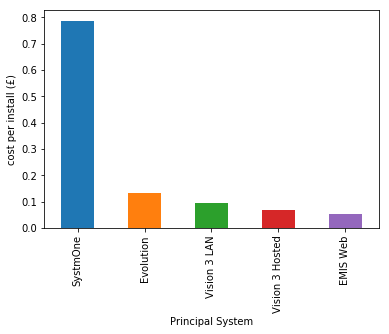

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt 
summary['cost_per_install'].plot.bar()
plt.ylabel("cost per install (£)")

# Create useful files for CCGs

In [178]:
summary = gpd_ghost_df.assign(saving_from_top_10 = None).set_index('ccg_id')
import string
for ccg_id in summary.index:
    ccg = ghost_df[ghost_df.ccg_id == ccg_id]
    top_presentations = ccg.groupby('bnf_description').sum().sort_values('excess_cost_dt', ascending=False).head(10).reset_index()[['bnf_description', 'excess_cost_dt']]
    target_prescriptions = top_presentations.merge(ccg, how='left', left_on='bnf_description', right_on='bnf_description').sort_values('excess_cost_dt_y', ascending=False)
    useful_cols = ['practice_code', 'bnf_description', 'bnf_code', 'items', 'excess_cost_dt_y']
    target_prescriptions = target_prescriptions[useful_cols]
    target_prescriptions.columns = ['practice_code', 'bnf_description', 'bnf_code', 'items', 'excess_cost']
    summary.loc[ccg_id, 'saving_from_top_10'] = target_prescriptions['excess_cost_dt_y'].sum()
    target_prescriptions.to_csv("csv_data/{}.csv".format(ccg_id))
summary = summary.reset_index()